### Classification

Use LM to classify articles into one/two pre-defined topics

In [1]:
import pandas as pd
import json

csv_path = "gpt4o-topic-assignments.csv"
topic = pd.read_csv(csv_path)
# print(topic.head())

json_path = "test_4o_mini_on_4o_questions_with_predictions.json"  # Replace with desired output path
with open(json_path, 'rb') as f:
    result_4o_mini_on_4o_Q = json.load(f)

df = result_4o_mini_on_4o_Q

# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(df, orient="index")
df.index.name = "qid"
df.reset_index(inplace=True)

# Create binary match indicators for analysis
df["answer_match"] = df["model_answer"] == df["ground_truth_answer"]
df["discrepancy_match"] = df["model_discrepancy"] == df["ground_truth_discrepancy"]
df["evidence_quality_match"] = df["model_evidence-quality"] == df["ground_truth_evidence-quality"]

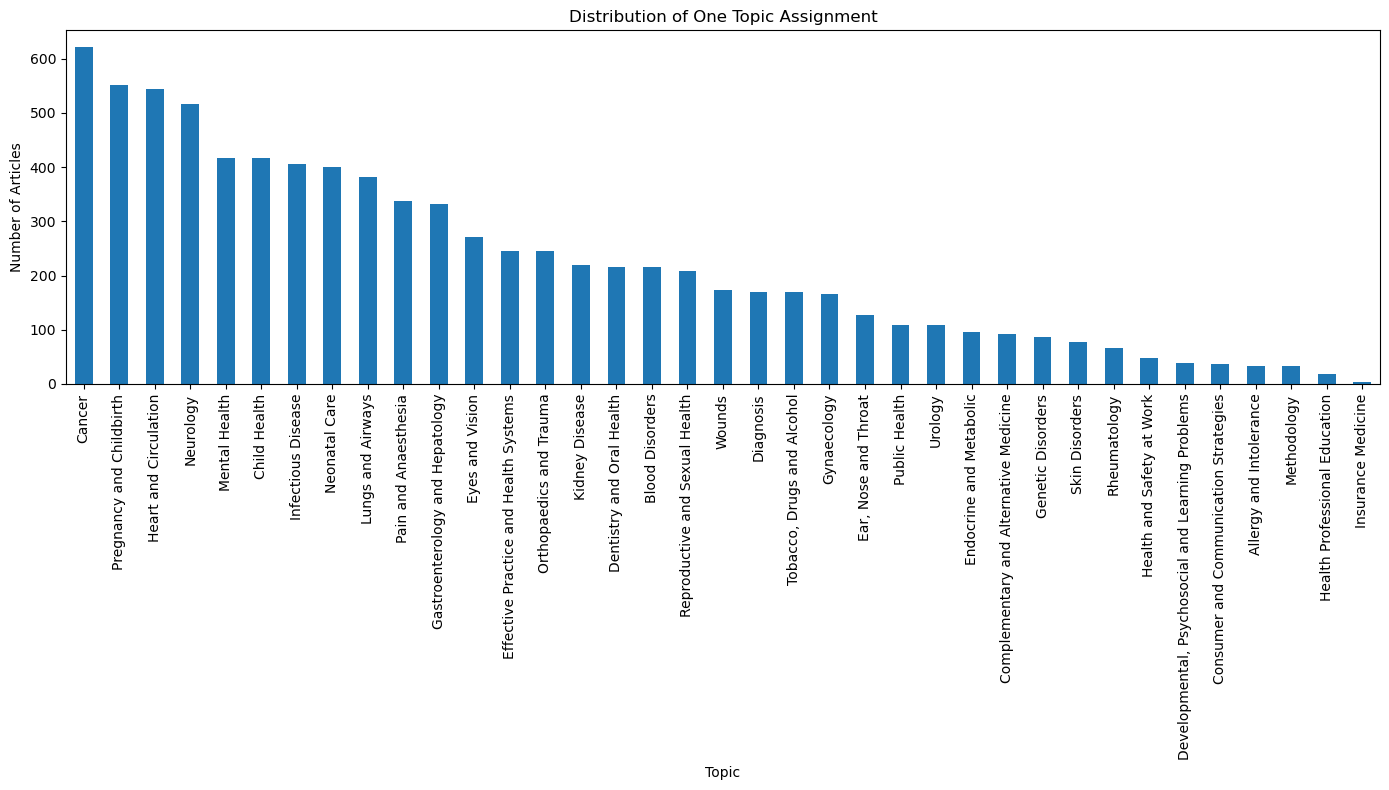

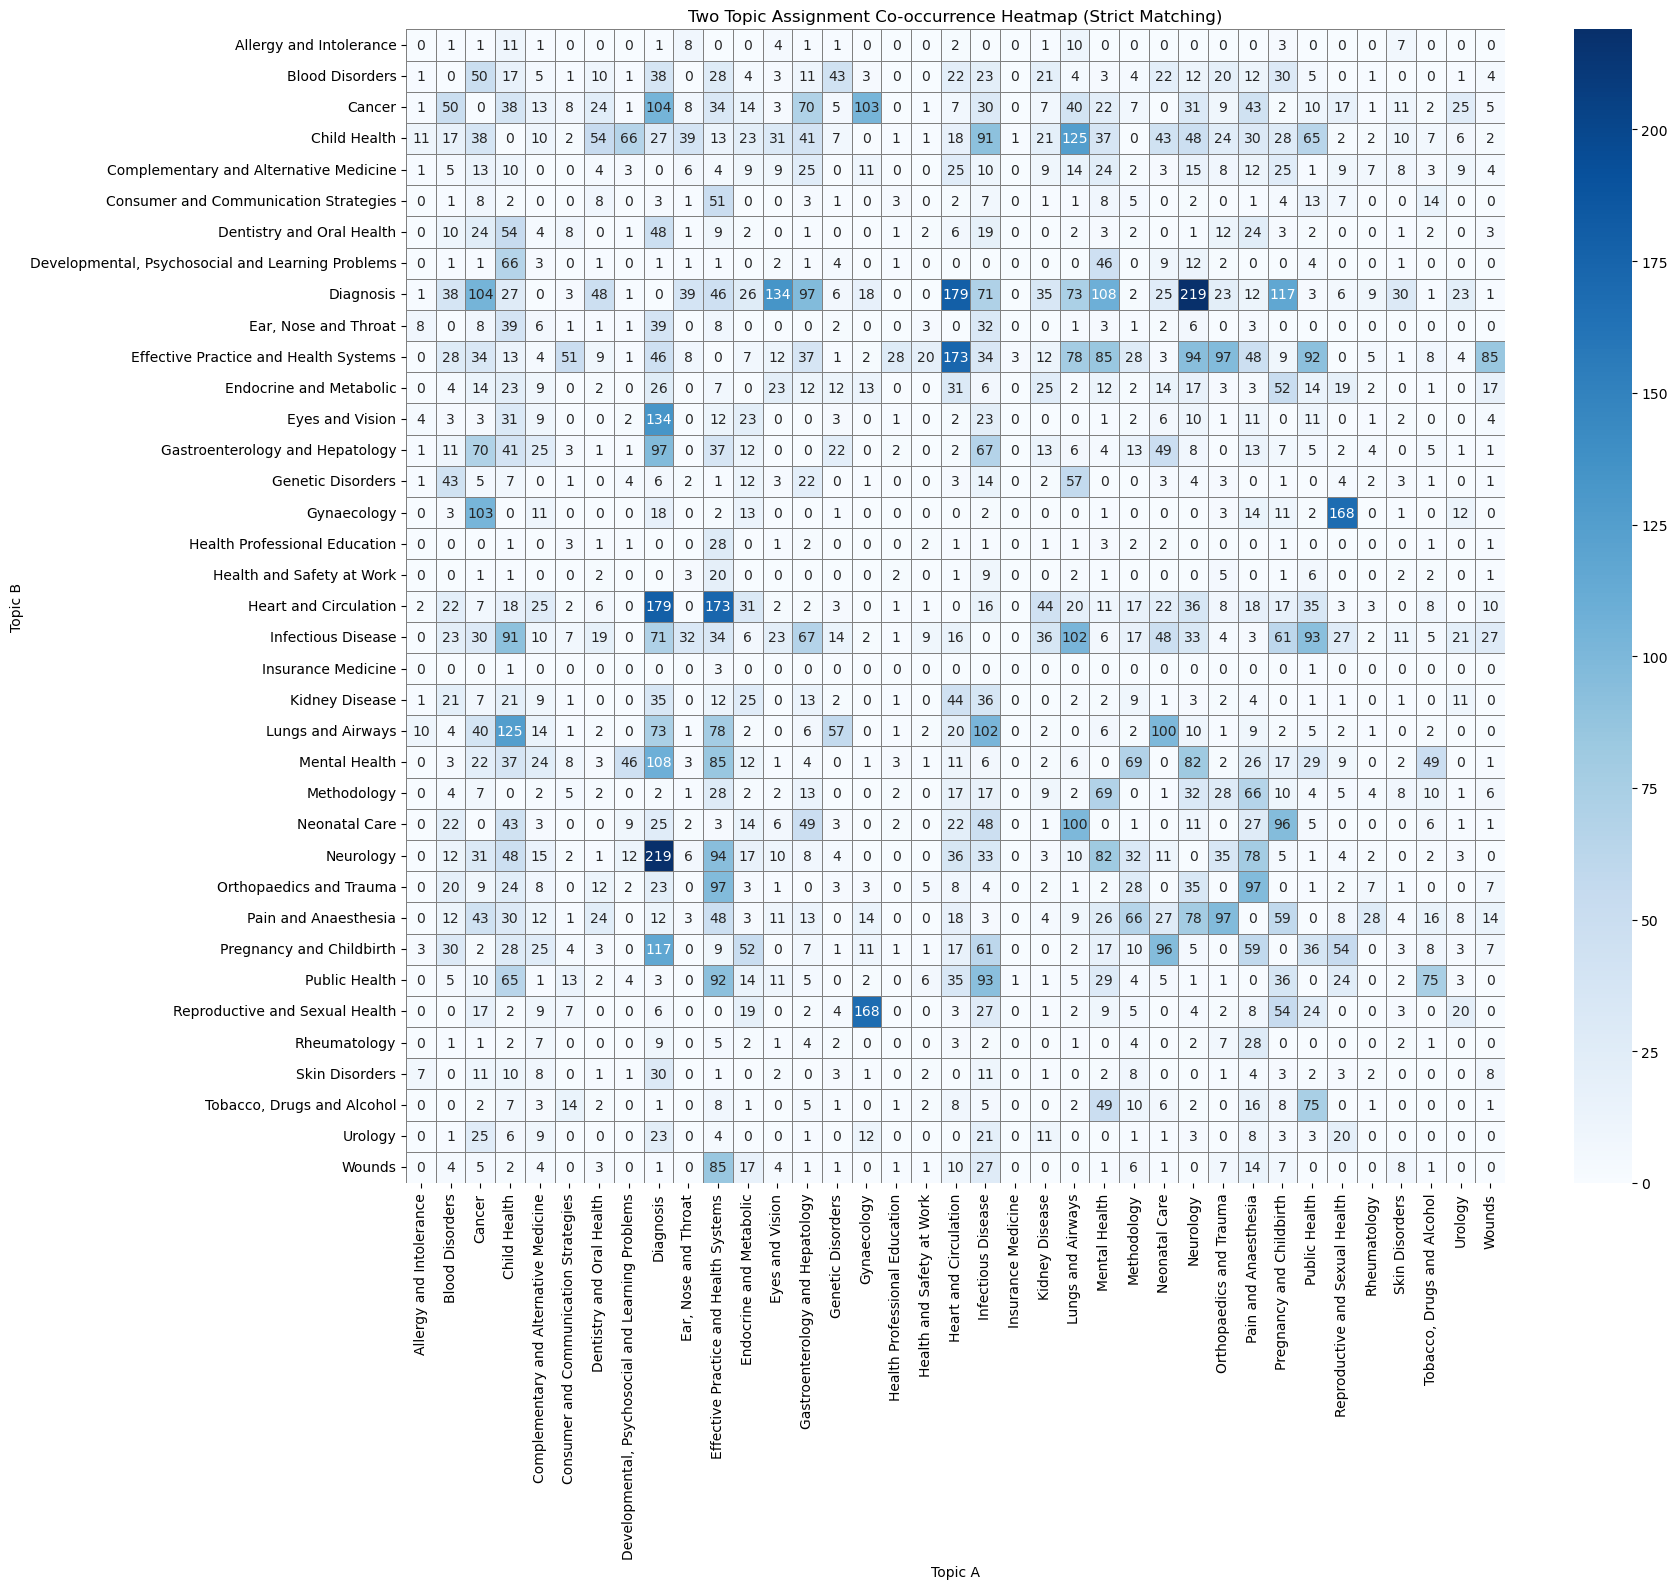

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Count the number of articles per topic
topic_counts = topic['one_topic_assignment'].value_counts()

# Plot
plt.figure(figsize=(14, 8))
topic_counts.plot(kind='bar')
plt.title('Distribution of One Topic Assignment')
plt.xlabel('Topic')
plt.ylabel('Number of Articles')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Full list of all known topics
topic_list = [
    "Allergy and Intolerance",
    "Blood Disorders",
    "Cancer",
    "Child Health",
    "Complementary and Alternative Medicine",
    "Consumer and Communication Strategies",
    "Dentistry and Oral Health",
    "Developmental, Psychosocial and Learning Problems",
    "Diagnosis",
    "Ear, Nose and Throat",
    "Effective Practice and Health Systems",
    "Endocrine and Metabolic",
    "Eyes and Vision",
    "Gastroenterology and Hepatology",
    "Genetic Disorders",
    "Gynaecology",
    "Health and Safety at Work",
    "Health Professional Education",
    "Heart and Circulation",
    "Infectious Disease",
    "Insurance Medicine",
    "Kidney Disease",
    "Lungs and Airways",
    "Mental Health",
    "Methodology",
    "Neonatal Care",
    "Neurology",
    "Orthopaedics and Trauma",
    "Pain and Anaesthesia",
    "Pregnancy and Childbirth",
    "Public Health",
    "Reproductive and Sexual Health",
    "Rheumatology",
    "Skin Disorders",
    "Tobacco, Drugs and Alcohol",
    "Urology",
    "Wounds"
]

# Match topics from two_topic_assignment
def extract_topics(text):
    found = []
    for topic_name in topic_list:
        if topic_name in str(text):
            found.append(topic_name)
    return found if len(found) == 2 else [None, None]

# Apply extraction
topic[['first_topic', 'second_topic']] = topic['two_topic_assignment'].apply(extract_topics).apply(pd.Series)

# Build a co-occurrence matrix
all_topics = sorted(set(topic_list))
co_matrix = pd.DataFrame(0, index=all_topics, columns=all_topics)

for _, row in topic.iterrows():
    t1, t2 = row['first_topic'], row['second_topic']
    if pd.notna(t1) and pd.notna(t2):
        co_matrix.at[t1, t2] += 1
        co_matrix.at[t2, t1] += 1  # Make it symmetric

# Plot the heatmap
plt.figure(figsize=(18, 16))
sns.heatmap(co_matrix, annot=True, fmt=".0f", cmap="Blues", linewidths=0.5, linecolor='gray')
plt.title("Two Topic Assignment Co-occurrence Heatmap (Strict Matching)")
plt.xlabel("Topic A")
plt.ylabel("Topic B")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


**Observations:**

1. A few dominant topics (e.g., Cancer, Pregnancy and Childbirth, Heart and Circulation, Neurology) account for a large proportion of total samples, reflecting their clinical importance and systematic review prevalence.

2. Auxiliary fields like Allergy and Intolerance, Health Professional Education, and Insurance Medicine have very low representation.

3. There's strong connection between certain topic pairs. eg. "Reproductive and Sexual Health" and "Gynaecology"; "Neurology" and "Diagnosis"

4. Certain topics like "Diagnosis" or "Effective Practice and Health Systems" demonstrate high cross-topic connectivity.

Top 5 Topics with Highest Answer Match Rate:
                            answer_match  article_count
one_topic_assignment                                   
Rheumatology                    0.727273             66
Pain and Anaesthesia            0.688427            337
Tobacco, Drugs and Alcohol      0.686391            169
Public Health                   0.685185            108
Urology                         0.675926            108

Bottom 5 Topics with Lowest Answer Match Rate:
                                        answer_match  article_count
one_topic_assignment                                               
Health and Safety at Work                   0.541667             48
Complementary and Alternative Medicine      0.532609             92
Dentistry and Oral Health                   0.532407            216
Neonatal Care                               0.505000            400
Wounds                                      0.433526            173




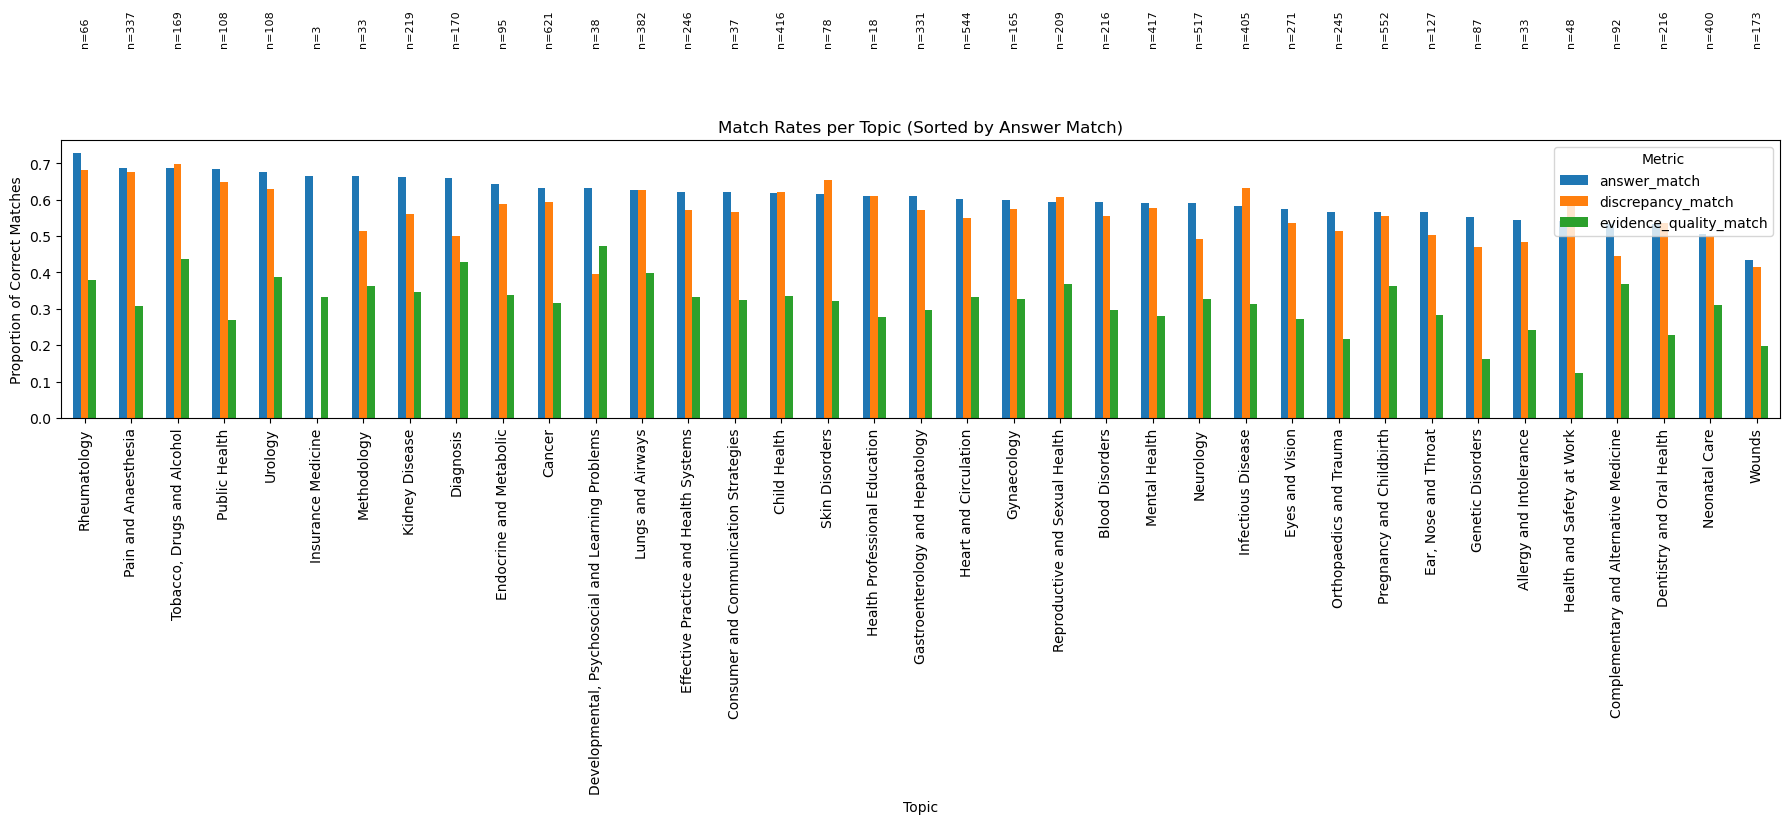

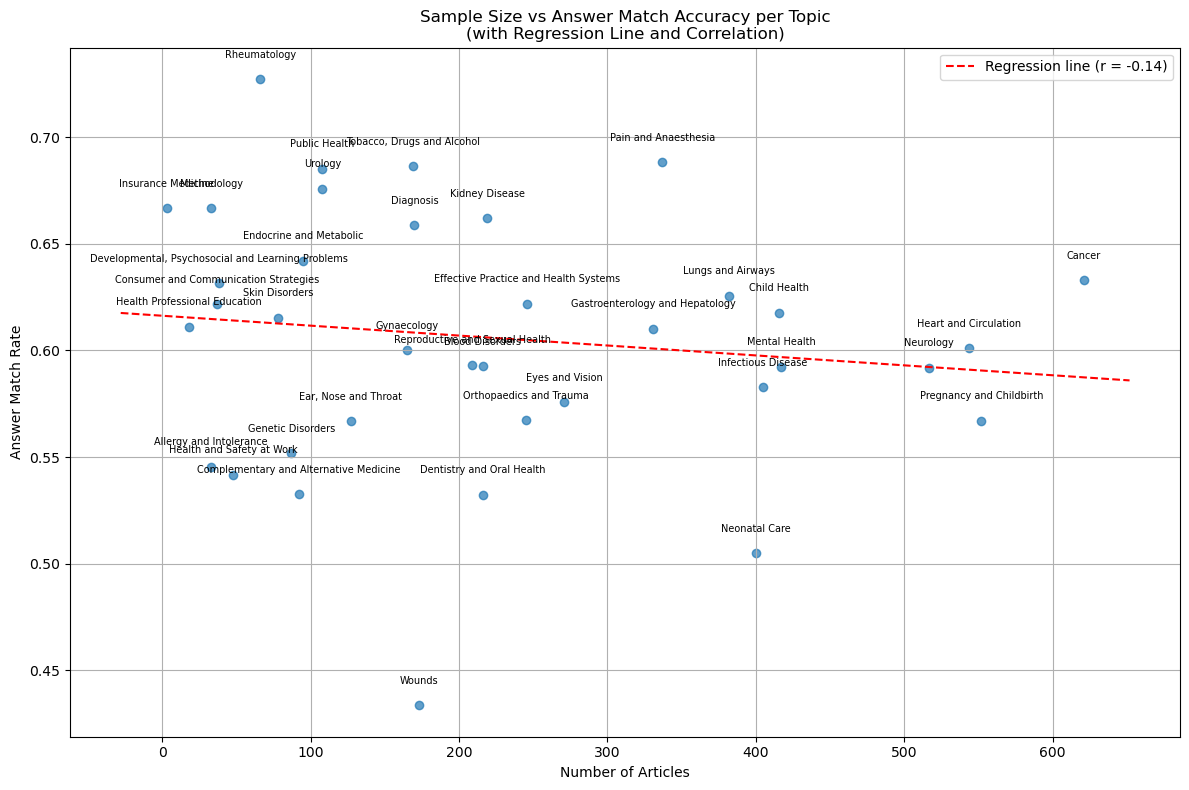

In [3]:
# Merge your answer-evaluation dataframe (df) with topic dataframe (topic) on 'doi'
df_with_topic = df.merge(topic[['doi', 'one_topic_assignment']], on='doi', how='left')



# Group by topic and calculate mean match rates
topic_accuracy = df_with_topic.groupby('one_topic_assignment')[['answer_match', 'discrepancy_match', 'evidence_quality_match']].mean()
topic_counts = df_with_topic['one_topic_assignment'].value_counts()

# Merge article counts
topic_accuracy['article_count'] = topic_counts

# Sort by answer_match
sorted_topic_accuracy = topic_accuracy.sort_values('answer_match', ascending=False)

# Top 5 Topics
top_topics = sorted_topic_accuracy.head(5)
print("Top 5 Topics with Highest Answer Match Rate:")
print(top_topics[['answer_match', 'article_count']])

# Bottom 5 Topics
bottom_topics = sorted_topic_accuracy.tail(5)
print("\nBottom 5 Topics with Lowest Answer Match Rate:")
print(bottom_topics[['answer_match', 'article_count']])
print("\n")







import matplotlib.pyplot as plt

# Group by topic: calculate mean match rates and article counts
topic_accuracy = df_with_topic.groupby('one_topic_assignment')[['answer_match', 'discrepancy_match', 'evidence_quality_match']].mean()
topic_counts = df_with_topic['one_topic_assignment'].value_counts()

# Merge article counts
topic_accuracy['article_count'] = topic_counts

# Sort ONLY by 'answer_match'
sorted_topic_accuracy = topic_accuracy.sort_values('answer_match', ascending=False)

# Plot
fig, ax = plt.subplots(figsize=(18, 10))
sorted_topic_accuracy[['answer_match', 'discrepancy_match', 'evidence_quality_match']].plot(kind='bar', ax=ax)

# Annotate article counts above the bars
for idx, (label, row) in enumerate(sorted_topic_accuracy.iterrows()):
    ax.text(idx, 1.02, f'n={int(row["article_count"])}', ha='center', va='bottom', fontsize=8, rotation=90)

plt.title('Match Rates per Topic (Sorted by Answer Match)')
plt.ylabel('Proportion of Correct Matches')
plt.xlabel('Topic')
plt.xticks(rotation=90)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()



import matplotlib.pyplot as plt
from scipy.stats import linregress

# Group by topic
topic_accuracy = df_with_topic.groupby('one_topic_assignment')[['answer_match']].mean()
topic_counts = df_with_topic['one_topic_assignment'].value_counts()

# Merge counts into accuracy
topic_accuracy['article_count'] = topic_counts

# Scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(topic_accuracy['article_count'], topic_accuracy['answer_match'], alpha=0.7)

# Regression line
slope, intercept, r_value, p_value, std_err = linregress(topic_accuracy['article_count'], topic_accuracy['answer_match'])
x_vals = np.array(plt.gca().get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, '--', color='red', label=f'Regression line (r = {r_value:.2f})')

# Add labels
for idx, row in topic_accuracy.iterrows():
    plt.text(row['article_count'], row['answer_match'] + 0.01, idx, fontsize=7, ha='center')

plt.title('Sample Size vs Answer Match Accuracy per Topic\n(with Regression Line and Correlation)')
plt.xlabel('Number of Articles')
plt.ylabel('Answer Match Rate')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()








**Observations**

1. Highest accuracy observed in Rheumatology, Pain and Anaesthesia, Tobacco, Drugs and Alcohol, Public Health, Urology, all above 67%.

2. Lowest accuracy in Wounds (43%), Neonatal Care (50%), Dentistry and Oral Health (53%), Complementary and Alternative Medicine (53%), Health and Safety at Work (54%), reflecting domain complexity and evidence variability.

3. Most topics fall within a 55%–65% accuracy range, showing moderate performance overall.

4. No strong correlation between article count and accuracy (r = –0.14); more articles do not imply better performance.

5. Small-topic domains vary widely, while high-volume topics like Cancer and Pregnancy show stable but average accuracy.